In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer as Lem
from nltk.tokenize import word_tokenize
import os

df_path = r'PATHos.chdir(df_path)

### Pre-processing

In [2]:
df = pd.read_csv('data.csv')
df.head()

,article_number,Current_Turn,Previous_Turns,Type_of_Thought/Belief
0,1,"A: I can see myself getting restless, I must b...",A: Work has been really busy lately. B: Have y...,Automatic Thought
1,2,"A: I feel like if I don't get this promotion, ...","A: I've been working so hard, but promotions a...",Intermediate Belief
2,3,"A: If I don't get everything perfect, they wil...",A: Tomorrow is my presentation and I am really...,Automatic Thought
3,4,"A: I always end up alone in social events, I g...",A: I dread going to parties... B: Have you had...,Intermediate Belief
4,5,A: If I don't perform perfectly on every proje...,A: Work has been so stressful lately... B: You...,Intermediate Belief


In [3]:
df = df.drop(columns='article_number',axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Current_Turn            1200 non-null   object
 1   Previous_Turns          1200 non-null   object
 2   Type_of_Thought/Belief  1200 non-null   object
dtypes: object(3)
memory usage: 28.3+ KB


In [18]:
df.Current_Turn.str.len().describe()

count    1200.00000
mean       75.77750
std        16.01838
min        35.00000
25%        65.00000
50%        76.00000
75%        86.00000
max       137.00000
Name: Current_Turn, dtype: float64

In [19]:
df.Previous_Turns.str.len().describe()

count    1200.000000
mean      106.832500
std        18.890743
min        55.000000
25%        94.000000
50%       106.000000
75%       118.000000
max       183.000000
Name: Previous_Turns, dtype: float64

In [23]:
df['Type_of_Thought/Belief'].value_counts(dropna=False)

Type_of_Thought/Belief
Automatic Thought      441
Intermediate Belief    430
Core Belief            329
Name: count, dtype: int64

In [51]:
Lemm = Lem()

def remove_labels(value):
    value = value.replace("A: ","")
    value = value.replace("B: ","")
    return value

def convert_target(value):
    if value == 'Automatic Thought': return 0
    elif value == 'Intermediate Belief': return 1
    else: return 2

def lemmatize(value):
    return [Lemm.lemmatize(w) for w in value]
    
class data_preprocessed:
    def __init__(self,df_path):
        self.df = pd.read_csv(df_path)
    
    def preprocess(self):
        self.df = self.df.drop(columns='article_number',axis=1)
        self.df['label'] = self.df['Type_of_Thought/Belief'].map(convert_target)
    
    def preprocess_plus(self):
        self.df['Current_Turn_v1'] = self.df['Current_Turn'].map(lambda v: v.lower())
        self.df['Current_Turn_v1'] = self.df['Current_Turn_v1'].map(lambda v: v[3:])
        self.df['Current_Turn_v1'] = self.df['Current_Turn_v1'].map(word_tokenize)
        self.df['Current_Turn_v1'] = self.df['Current_Turn_v1'].map(lemmatize)
        
        self.df['Previous_Turns_v1'] = self.df['Previous_Turns'].map(lambda v: v.lower())
        self.df['Previous_Turns_v1'] = self.df['Previous_Turns_v1'].map(remove_labels)
        self.df['Previous_Turns_v1'] = self.df['Previous_Turns_v1'].map(word_tokenize)
        self.df['Previous_Turns_v1'] = self.df['Previous_Turns_v1'].map(lemmatize)

Bonus:
- compute NB likelihoods

### Feature Analysis

In [52]:
df_obj = data_preprocessed('data.csv')
df_obj.preprocess()
df_obj.preprocess_plus()
df = df_obj.df

#### Word Cloud

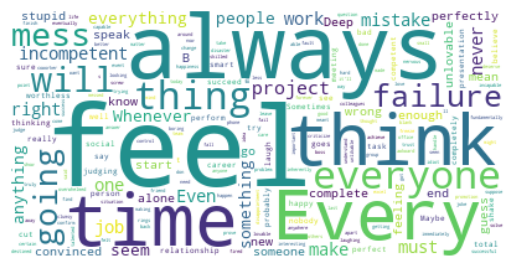

<Figure size 3000x2000 with 0 Axes>

In [53]:
text = ' '.join(df.Current_Turn.tolist())
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(30,20))
plt.show()

### Word Count
Bonus:
- Remove stop words
- Lemmatize

In [23]:
from nltk.classify import naivebayes as nb

In [86]:
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.feature_extraction.text import CountVectorizer

In [84]:
cv = CountVectorizer(max_features=800)
X = cv.fit_transform(df['Current_Turn'].tolist()) #get_feature_names_out()
y = df['label'].tolist()
gnb = GNB()
gnb.fit(X.toarray(),y)
nb_prob = pd.DataFrame(gnb.theta_.T,index=cv.get_feature_names_out(),columns=['Automatic Thought','Intermediate Belief','Core Belief'])

In [104]:
nb_prob = nb_prob.sort_values(by=['Automatic Thought'],ascending=False)
nb_prob.iloc[:5]

,Automatic Thought,Intermediate Belief,Core Belief
to,0.335601,0.316279,0.279635
it,0.331066,0.369767,0.206687
just,0.328798,0.211628,0.395137
up,0.310658,0.144186,0.106383
time,0.287982,0.065116,0.015198


In [105]:
nb_prob = nb_prob.sort_values(by=['Intermediate Belief'],ascending=False)
nb_prob.iloc[:5]

,Automatic Thought,Intermediate Belief,Core Belief
if,0.092971,0.486047,0.097264
it,0.331066,0.369767,0.206687
this,0.122449,0.344186,0.060790
to,0.335601,0.316279,0.279635
not,0.070295,0.290698,0.246201


In [106]:
nb_prob = nb_prob.sort_values(by=['Core Belief'],ascending=False)
nb_prob.iloc[:5]

,Automatic Thought,Intermediate Belief,Core Belief
just,0.328798,0.211628,0.395137
like,0.249433,0.272093,0.361702
always,0.213152,0.125581,0.340426
to,0.335601,0.316279,0.279635
that,0.158730,0.125581,0.267477
